Import

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
directory = '/content/gdrive/MyDrive/EURUSD_H1.csv'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import dask.dataframe as dd
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


Pre-Process


In [ ]:

# Load your CSV file
df = pd.read_csv(directory)

# Drop unnecessary columns
df = df.drop(["Date", "Time", "Open"], axis=1)

# Normalize the "Volume" column
#scaler_volume = MinMaxScaler()
#df["Volume"] = scaler_volume.fit_transform(df["Volume"].values.reshape(-1, 1))

# Function to scale "High", "Low", and "Close" for each sequence
def scale_sequence(sequence):
    scaler = MinMaxScaler(feature_range=(0, 1))
    sequence[["Volume"]] = scaler.fit_transform(sequence[["Volume"]])
    maxVal = sequence["High"].max()
    minVal = sequence["Low"].min()
    sequence[["High", "Low", "Close"]] = (sequence[["High", "Low", "Close"]] - minVal) / (maxVal - minVal) * (0.9 - 0.1) + 0.1
    return maxVal, minVal, sequence

# Create lists for features and targets
features = []
targets = []

window_size = 504
future_steps = 12
MaxMin = []
for i in range(len(df) - (window_size + future_steps)):
    sequence = df.iloc[i:i + window_size].copy()

    # Scale features
    maxVal, minVal, sequence[["High", "Low", "Close", "Volume"]] = scale_sequence(sequence)
    features.append(sequence[["High", "Low", "Close", "Volume"]])
    # Extract target values and scale them
    target_max_high = df.iloc[i+window_size:i+window_size + future_steps]["High"].max()
    target_min_low = df.iloc[i+window_size:i+window_size + future_steps]["Low"].min()
    '''
    close           = df.iloc[i+window_size-1]["Close"].mean()
    label = 0
    if target_min_low >= close:
      label = 1
    elif target_max_high <= close:
      label = -1
    elif abs((target_max_high-close)/(target_min_low-close))>2:
      label = 1
    elif abs((target_max_high-close)/(target_min_low-close))<1/2:
      label = -1
    targets.append(label)
    '''
    MaxMin.append([maxVal, minVal])
    temp_target = ([target_max_high, target_min_low]- minVal) / (maxVal - minVal) * (0.9 - 0.1) + 0.1
    target_max_high_scaled, target_min_low_scaled = 1/(1+np.exp(-5.4931*temp_target+2.7465))
    targets.append([target_max_high_scaled, target_min_low_scaled])


# Convert lists to NumPy arrays
features_array = np.array(features)
targets_array = np.array(targets)
MaxMin_array  = np.array(MaxMin)
# Print the shapes of the arrays
print("Features shape:", features_array.shape)
print("Targets shape:", targets_array.shape)
print("MaxMin shape:", MaxMin_array.shape)



Features shape: (99484, 504, 4)
Targets shape: (99484, 2)
MaxMin shape: (99484, 2)


In [ ]:
np.save("features_array.npy", features_array)
np.save("targets_array.npy", targets_array)
np.save("MaxMin_array.npy", MaxMin_array)

In [ ]:
features_array = np.load("features_array.npy")
targets_array = np.load("targets_array.npy")
MaxMin_array = np.load("MaxMin_array.npy")

Spilt the data X_train & X_test

In [ ]:
test_size = 0.2  # Adjust as needed
random_state = 42  # Set a random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    features_array, targets_array, test_size=test_size, shuffle=False, random_state=random_state
)
np.random.seed(random_state)  # Set the seed for reproducibility
shuffle_indices = np.arange(X_train.shape[0])
np.random.shuffle(shuffle_indices)

X_train = X_train[shuffle_indices]
y_train = y_train[shuffle_indices]

MaxMin_train = MaxMin_array[:len(X_train),:]
MaxMin_train = MaxMin_train[shuffle_indices]
MaxMin_test  = MaxMin_array[len(X_train):,:]

In [ ]:
print(features_array.shape)
print(targets_array.shape)

(99484, 504, 4)
(99484, 2)


In [ ]:
X_subset = X_train[random_indices]
y_subset = y_train[random_indices]


NameError: ignored

Apply Ridge Regression


In [ ]:
# Generate random indices to select 1000 random datapoints
sized = len(X_train)
random_indices = np.random.choice(len(X_train), size=sized, replace=False)
y_pred = []

# Select the subset of data
X_subset = X_train[random_indices]
y_subset = y_train[random_indices]
#y_subset = np.reshape(y_subset,[1,2])
X_subset = X_subset.reshape([sized,-1])
# Apply Ridge Regression
alpha = 1.0  # You can adjust the regularization strength
ridge_model = Ridge(alpha=alpha)

ridge_model.fit(X_subset, y_subset)

y_pred_subset = ridge_model.predict(X_subset)
y_pred.append(y_pred_subset)

# Evaluate the model
mse = mean_squared_error(y_train[random_indices], y_pred_subset)
print(f'Mean Squared Error: {mse}')

NameError: ignored

In [ ]:
X_subset = X_test.reshape([len(X_test),-1])
y_pred_subset = ridge_model.predict(X_subset)
mse = mean_squared_error(y_test, y_pred_subset)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0037162246271593546


Generating Multiple Alphas


In [ ]:
# Generate random indices to select 1000 random datapoints
sized = len(X_train)
random_indices = np.random.choice(len(X_train), size=sized, replace=False)
y_pred = []
# Select the subset of data
X_subset_ = X_train[random_indices]
y_subset_ = y_train[random_indices]
#y_subset = np.reshape(y_subset,[1,2])
X_subset_ = X_subset_.reshape([sized,-1])

# Apply Ridge Regression
alpha_values = np.linspace(10, 550, num=60 )

mse_values_pred = []
mse_values_test = []

for alpha in alpha_values:
  ridge_model = Ridge(alpha=alpha)

  ridge_model.fit(X_subset_, y_subset_)

  y_pred_subset_ = ridge_model.predict(X_subset_)
  y_pred.append(y_pred_subset_)

  # Evaluate the model
  mse_pred = mean_squared_error(y_train[random_indices], y_pred_subset_)
  mse_values_pred.append(mse_pred)
  #print(f'Mean Squared Error: {mse_pred}')

  X_subset = X_test.reshape([len(X_test),-1])
  y_pred_subset = ridge_model.predict(X_subset)
  mse_test = mean_squared_error(y_test, y_pred_subset)
  mse_values_test.append(mse_test)

print(f'Mean Squared Error: {mse_values_pred}')
print(f'Mean Squared Error: {mse_values_test}')


Mean Squared Error: [0.0035642486646374275, 0.0035911462758151445, 0.0036142348964963555, 0.00363483972920491, 0.003653597994928855, 0.0036709116467819776, 0.0036870583724383328, 0.0037022396173729743, 0.0037166066207213917, 0.0037302760342661856, 0.003743339859042084, 0.003755872034843029, 0.0037679329555890496, 0.003779572649149891, 0.0037908330698810354, 0.0038017497857746434, 0.003812353242869844, 0.003822669728343695, 0.003832722114855469, 0.0038425304434458163, 0.0038521123854902005, 0.0038614836128051055, 0.003870658097132387, 0.0038796483547012504, 0.0038884656476259804, 0.0038971201510496155, 0.003905621092861599, 0.003913976871270561, 0.003922195154359275, 0.003930282964871841, 0.003938246752816851, 0.003946092457951432, 0.003953825563814472, 0.003961451144660602, 0.0039689739063990485, 0.00397639822244529, 0.0039837281652362316, 0.003990967534029909, 0.003998119879511449, 0.004005188525641469, 0.004012176589113027, 0.004019086996730802, 0.0040259225009746415, 0.0040326856939

(79587, 2016)
(79587, 2)


Plotting


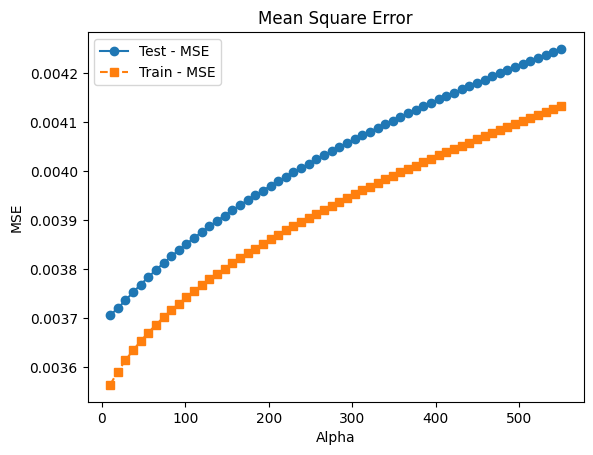

In [ ]:
import matplotlib.pyplot as plt

# Example x values
x_values = alpha_values

# Example y values for two lines
y_values_line1 =  mse_values_test
y_values_line2 = mse_values_pred

# Plotting the first line
plt.plot(x_values, y_values_line1, label='Test - MSE', marker='o', linestyle='-')

# Plotting the second line
plt.plot(x_values, y_values_line2, label='Train - MSE', marker='s', linestyle='--')

# Adding labels and title
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Mean Square Error')

# Adding a legend
plt.legend()

# Display the plot
plt.show()
